In [1]:
### IMPORTS

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

In [2]:
### FUNCTIONS

## Min-Max Normalization
# X: array to be normalized
def normalize(X):
    X_norm = (X-np.min(X, axis=0))/(np.max(X, axis=0) - np.min(X, axis=0))
    return X_norm

## Univariate Gradient Descent
# X: feature vector
# y: target vector
# alpha: step size
# max_iter: number of iterations 
def uni_gradient_descent(X, y, alpha, max_iter):
    m = 1
    b = 1
    n = len(X)
    for i in range(max_iter):
        m_gradient = np.mean(-2*X*(y - (m*X + b)))
        b_gradient = np.mean(-2*(y - (m*X + b)))
        m = m - alpha*m_gradient
        b = b - alpha*b_gradient
    return m, b

### Multivariate Gradient Descent
# X: feature array 
# y: target vector
# alpha: step size
# max_iter: number of iterations 
def multi_gradient_descent(X, y, alpha, max_iter):
    if (X.ndim == 1):
        X = X.reshape(1, -1)
    n, num_feats = X.shape
    m = np.ones((num_feats,1))
    b = 1
    for i in range(max_iter):
        m_gradient = np.sum(-2*(y - (X@m + b))*X, axis=0).reshape(1, -1).transpose()
        b_gradient = np.sum(-2*(y - (X@m + b)))
        m = m - alpha*m_gradient/n
        b = b - alpha*b_gradient/n
    return m, b

### Multivariate Gradient Descent w/ MSE
# X: feature array 
# y: target vector
# alpha: step size
# max_iter: number of iterations 
def multi_gradient_descent_MSE(X, y, alpha, max_iter):
    if (X.ndim == 1):
        X = X.reshape(1, -1)
    n, num_feats = X.shape
    m = np.ones((num_feats,1))
    MSE = []
    b = 1
    for i in range(max_iter):
        m_gradient = np.sum(-2*(y - (X@m + b))*X, axis=0).reshape(1, -1).transpose()
        b_gradient = np.sum(-2*(y - (X@m + b)))
        m = m - alpha*m_gradient/n
        b = b - alpha*b_gradient/n
        MSE.append(mean_squared_error(y, X@m + b))
    return m, b, MSE

In [3]:
### PREPROCESSING I

# read data set
data = pd.read_csv(r"C:\Users\kingh\Downloads\Concrete_Data.csv")

# extract feature variables
X = data.iloc[:,:8].to_numpy()
X_test = X[501:631, :]
X_train = np.vstack((X[0:501, :], X[631:, :]))

# extract target variable
y = data.iloc[:, -1].to_numpy().reshape((-1,1))
y_test = y[501:631]
y_train = np.vstack((y[0:501], y[631:]))

In [4]:
### PREPROCESSING II

# create normalized X
X_train_norm = normalize(X_train)
X_test_norm = normalize(X_test)

# UNIVARIATE LINEAR MODELS

## NORMALIZED PREDICTORS

In [5]:
### GRID SEARCH FOR OPTIMAL HYPERPARAMS (UNIVARIATE, NORMALIZED)

alpha_values = np.logspace(-8, -3, 10)
max_iter_values = np.logspace(1, 3, 5, dtype=int)
best_m = None
best_b = None
best_VE_train = None
best_params = None
best_VE = None
best_avg_VE = -np.inf

for alpha in alpha_values:
    for max_iter in max_iter_values:
        
        # initialize parameters
        num_feats = len(X_train_norm[0])          # number of features
        
        # conduct gradient descent to obtain a univariate linear regression model for each feature
        m = np.zeros(num_feats)
        b = np.zeros(num_feats)
        for i in range(num_feats):
            X_i = X_train_norm[:, i].reshape((-1,1))
            m_i, b_i = uni_gradient_descent(X_i, y_train, alpha, max_iter)
            m[i] = m_i
            b[i] = b_i
        
        # evaluate variances
        var_train = np.var(y_train)
        var_test = np.var(y_test)
        
        # model predictions
        m = m.reshape(-1,1)
        b = b.reshape(-1,1)
        y_train_pred = (X_train_norm.transpose()*m + b).transpose()
        y_test_pred = (X_test_norm.transpose()*m + b).transpose()
        
        # train + test MSE
        train_MSE = np.mean((y_train_pred - np.tile(y_train, (1, num_feats)))**2, axis=0)
        test_MSE  = np.mean((y_test_pred - np.tile(y_test, (1, num_feats)))**2, axis=0)
        
        # train + test VE
        train_VE = 1 - (train_MSE / var_train)
        test_VE  = 1 - (test_MSE / var_test)
        
        # update best model based on average train VE
        if np.mean(train_VE) > best_avg_VE:
            best_avg_VE = np.mean(train_VE)
            best_VE = test_VE
            best_params = [alpha, max_iter]
            best_m = m
            best_b = b
            best_VE_train = train_VE

print("Best Average Train VE:", best_avg_VE)
print("Best Parameters:", best_params)
print("Best Test VE:", best_VE)
print("Corresponding Train VE:", best_VE_train)
print("m:", best_m)
print("b:", best_b)

Best Average Train VE: -0.053353590339357534
Best Parameters: [0.001, 1000]
Best Test VE: [ 0.00072418 -0.13550305  0.05857924 -0.29597445  0.09836463 -0.41566435
 -0.26336916 -0.05752401]
Corresponding Train VE: [ 0.14229641 -0.03974582 -0.13704715 -0.12694088 -0.01299616 -0.10974377
 -0.10767421 -0.03497713]
m: [[14.82261933]
 [ 8.86393444]
 [ 6.28057738]
 [11.55899224]
 [ 8.89856738]
 [12.38175904]
 [11.4646642 ]
 [ 6.49420175]]
b: [[27.96240104]
 [30.53586387]
 [30.68372789]
 [28.05459217]
 [30.79594057]
 [27.48930174]
 [28.31462125]
 [31.56115065]]


In [6]:
### TRAIN + ANALYZE UNIVARIATE MODELS (NORMALIZED)

# initialize parameters
num_feats = len(X_train_norm[0])          # number of features
alpha = 0.4756                              # learning rate       
max_iter = 1000                            # number of iterations

# conduct gradient descent to obtain a univariate linear regression model for each feature
m = np.zeros(num_feats)
b = np.zeros(num_feats)
for i in range(num_feats):
    X_i = X_train_norm[:, i].reshape((-1,1))
    m_i, b_i = uni_gradient_descent(X_i, y_train, alpha, max_iter)
    m[i] = m_i
    b[i] = b_i

# evaluate variances
var_train = np.var(y_train)
var_test = np.var(y_test)

# model predictions
m = m.reshape(-1,1)
b = b.reshape(-1,1)
y_train_pred = (X_train_norm.transpose()*m + b).transpose()
y_test_pred = (X_test_norm.transpose()*m + b).transpose()

# train + test MSE
train_MSE = np.mean((y_train_pred - np.tile(y_train, (1, num_feats)))**2, axis=0)
test_MSE  = np.mean((y_test_pred - np.tile(y_test, (1, num_feats)))**2, axis=0)

# train + test VE
train_VE = 1 - (train_MSE / var_train)
test_VE  = 1 - (test_MSE / var_test)

# rounding for ease of interpretation + postprocessing
m_uvnorm = np.round_(m, decimals=3)
b_uvnorm = np.round_(b, decimals=3)
train_MSE_uvnorm = np.round_(train_MSE, decimals=2).reshape(-1,1)
test_MSE_uvnorm  = np.round_(test_MSE, decimals=2).reshape(-1,1)
train_VE_uvnorm = np.round_(train_VE, decimals=4).reshape(-1,1)
test_VE_uvnorm  = np.round_(test_VE, decimals=4).reshape(-1,1)

print("m:", m_uvnorm)
print("b:", b_uvnorm)
print("Test VE:", test_VE_uvnorm)
print("Train VE:", train_VE_uvnorm)
print("Test MSE:", test_MSE_uvnorm)
print("Train MSE:", train_MSE_uvnorm)

m: [[ 35.383]
 [  9.53 ]
 [-10.67 ]
 [-25.778]
 [ 28.434]
 [ -9.442]
 [-12.209]
 [ 34.577]]
b: [[22.741]
 [34.595]
 [40.039]
 [49.107]
 [30.907]
 [41.705]
 [42.429]
 [32.693]]
Test VE: [[-0.2642]
 [-0.3805]
 [-0.8215]
 [-0.1709]
 [ 0.1017]
 [-0.256 ]
 [-0.3409]
 [-0.3583]]
Train VE: [[0.2655]
 [0.0248]
 [0.0423]
 [0.0759]
 [0.1005]
 [0.0164]
 [0.0227]
 [0.1223]]
Test MSE: [[275.26]
 [300.58]
 [396.61]
 [254.96]
 [195.59]
 [273.48]
 [291.97]
 [295.75]]
Train MSE: [[203.53]
 [270.2 ]
 [265.35]
 [256.05]
 [249.24]
 [272.55]
 [270.79]
 [243.19]]


## RAW PREDICTORS

In [7]:
### GRID SEARCH FOR OPTIMAL HYPERPARAMS (UNIVARIATE, RAW)

feature_to_test = 1
alpha_values = np.logspace(-8, -3, 10)
max_iter_values = np.logspace(1, 3, 5, dtype=int)
best_m = None
best_b = None
best_VE_train = None
best_params = None
best_VE = None
best_avg_VE = -np.inf

for alpha in alpha_values:
    for max_iter in max_iter_values:
        # initialize parameters
        num_feats = len(X_train[0])          # number of features
        
        # conduct gradient descent to obtain a univariate linear regression model for each feature
        m = np.zeros(num_feats)
        b = np.zeros(num_feats)
        for i in range(num_feats):
            X_i = X_train[:, i].reshape((-1,1))
            m_i, b_i = uni_gradient_descent(X_i, y_train, alpha, max_iter)
            m[i] = m_i
            b[i] = b_i
        
        # evaluate variances
        var_train = np.var(y_train)
        var_test = np.var(y_test)
        
        # model predictions
        m = m.reshape(-1,1)
        b = b.reshape(-1,1)
        y_train_pred = (X_train.transpose()*m + b).transpose()
        y_test_pred = (X_test.transpose()*m + b).transpose()
        
        # train + test MSE
        train_MSE = np.mean((y_train_pred - np.tile(y_train, (1, num_feats)))**2, axis=0)
        test_MSE  = np.mean((y_test_pred - np.tile(y_test, (1, num_feats)))**2, axis=0)
                
        # train + test VE
        train_VE = 1 - (train_MSE / var_train)
        test_VE  = 1 - (test_MSE / var_test)

        # update best model based on train VE
        if train_VE[feature_to_test] > best_avg_VE:
            best_avg_VE = train_VE[feature_to_test]
            best_VE = test_VE
            best_params = [alpha, max_iter]
            best_m = m
            best_b = b
            best_VE_train = train_VE

print("Best Parameters:", best_params)
print("Best Test VE:", best_VE)
print("Corresponding Train VE:", best_VE_train)
print("m:", best_m)
print("b:", best_b)

C:\Users\kingh\miniconda3\envs\cse2107\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\kingh\AppData\Local\Temp\ipykernel_24956\1397851816.py:21: RuntimeWarning: invalid value encountered in double_scalars
  m = m - alpha*m_gradient
C:\Users\kingh\AppData\Local\Temp\ipykernel_24956\3475226586.py:38: RuntimeWarning: overflow encountered in square
  train_MSE = np.mean((y_train_pred - np.tile(y_train, (1, num_feats)))**2, axis=0)
C:\Users\kingh\AppData\Local\Temp\ipykernel_24956\3475226586.py:39: RuntimeWarning: overflow encountered in square
  test_MSE  = np.mean((y_test_pred - np.tile(y_test, (1, num_feats)))**2, axis=0)
C:\Users\kingh\AppData\Local\Temp\ipykernel_24956\1397851816.py:19: RuntimeWarning: invalid value encountered in multiply
  m_gradient = np.mean(-2*X*(y - (m*X + b)))
C:\Users\kingh\AppData\Local\Temp\ipykernel_24956\1397851816.py:20: RuntimeWarning: inva

Best Parameters: [7.742636826811278e-05, 1000]
Best Test VE: [        nan -2.93176516 -1.1609454          nan -1.43520318         nan
         nan -2.33964926]
Corresponding Train VE: [        nan -1.86234298 -2.52907085         nan -1.1015818          nan
         nan -1.76792931]
m: [[       nan]
 [0.21408177]
 [0.22390229]
 [       nan]
 [3.19931931]
 [       nan]
 [       nan]
 [0.31932661]]
b: [[       nan]
 [3.73393931]
 [4.20967895]
 [       nan]
 [3.10099419]
 [       nan]
 [       nan]
 [3.97308755]]


In [8]:
### TRAIN + ANALYZE UNIVARIATE MODELS (RAW)

# initialize parameters
num_feats = len(X_train[0])              # number of features
alpha = 1.053e-5                              # learning rate       
max_iter = 33                            # number of iterations

# conduct gradient descent to obtain a univariate linear regression model for each feature
m = np.zeros(num_feats)
b = np.zeros(num_feats)
for i in range(num_feats):
    X_i = X_train[:, i].reshape((-1,1))
    m_i, b_i = uni_gradient_descent(X_i, y_train, alpha, max_iter)
    m[i] = m_i
    b[i] = b_i

# evaluate variances
var_train = np.var(y_train)
var_test = np.var(y_test)

# model predictions
m = m.reshape(-1,1)
b = b.reshape(-1,1)
y_train_pred = (X_train.transpose()*m + b).transpose()
y_test_pred = (X_test.transpose()*m + b).transpose()

# train + test MSE
train_MSE = np.mean((y_train_pred - np.tile(y_train, (1, num_feats)))**2, axis=0)
test_MSE  = np.mean((y_test_pred - np.tile(y_test, (1, num_feats)))**2, axis=0)

# train + test VE
train_VE = 1 - (train_MSE / var_train)
test_VE  = 1 - (test_MSE / var_test)

print("m", m)
print("b", b)
print("Test VE:", test_VE)
print("Train VE:", train_VE)
print("Test MSE:", test_MSE)
print("Train MSE:", train_MSE)

m [[ 1.15280794e-01]
 [ 2.30190712e-01]
 [ 2.51390540e-01]
 [ 1.92988180e-01]
 [ 1.13224865e+00]
 [-1.75759647e+42]
 [-1.69009047e+35]
 [ 3.50960399e-01]]
b [[ 9.98416977e-01]
 [ 1.00825782e+00]
 [ 1.00926530e+00]
 [ 9.96362741e-01]
 [ 1.01991034e+00]
 [-1.79417194e+39]
 [-2.16439507e+32]
 [ 1.00894937e+00]]
Test VE: [ 3.52251366e-02 -3.47746180e+00 -1.63391312e+00 -5.25086838e-01
 -2.63285164e+00 -1.34187267e+88 -8.10584497e+73 -2.96999753e+00]
Train VE: [ 1.61971603e-01 -2.21041149e+00 -3.00916814e+00 -2.13319094e-01
 -2.77251412e+00 -1.06315387e+88 -6.21594787e+73 -2.18117489e+00]
Test MSE: [2.10069308e+02 9.74918954e+02 5.73506138e+02 3.32071189e+02
 7.91014212e+02 2.92178283e+90 1.76496021e+76 8.64424089e+02]
Train MSE: [2.32201180e+02 8.89541859e+02 1.11086161e+03 3.36186849e+02
 1.04528944e+03 2.94579020e+90 1.72231685e+76 8.81440971e+02]


In [9]:
### BEST HYPERPARAMETER PAIRS FOR UNIVARIATE, RAW MODELS
# [1.053e-5, 33] # cement
# [7.554e-05, 31] # blast furnace slag
# [1.3445e-4, 10000] # fly ash
# [2.9e-05, 500] # water
# [0.001, 10000] # superplasticizer
# [9.651254005555555e-07, 31] # coarse aggregate
# [1.5777402395e-06, 10000] # fine aggregate
# [0.0001, 15000] # age

In [10]:
### TRAIN UNIVARIATE MODELS (RAW) USING BEST HYPERPARAM PAIRS FOR EACH FEATURE + STORE RESULTS FOR POSTPROCESSING

best_hyperparams = np.array([[1.053e-5, 33], [7.554e-5, 31], [1.3445e-4, 10000], [2.9e-5, 500], [0.001, 10000], [9.6513e-7, 31], [1.5777e-6, 10000], [0.0001, 15000]])
m_uvraw = []
b_uvraw = []
train_MSE_uvraw = []
train_VE_uvraw = []
test_MSE_uvraw = []
test_VE_uvraw = []

i = 0
for params in best_hyperparams:
    # initialize parameters
    alpha = params[0]                              # learning rate       
    max_iter = int(params[1])                            # number of iterations
    
    # conduct gradient descent to obtain a univariate linear regression model for each feature
    X_i = X_train[:, i].reshape((-1,1))
    m, b = uni_gradient_descent(X_i, y_train, alpha, max_iter)
    
    # evaluate variances
    var_train = np.var(y_train)
    var_test = np.var(y_test)
    
    # model predictions
    y_train_pred = (X_i*m + b)
    y_test_pred = (X_test[:, i].reshape((-1,1))*m + b)
    
    # train + test MSE
    train_MSE = np.mean((y_train_pred - y_train)**2)
    test_MSE  = np.mean((y_test_pred - y_test)**2)
    
    # train + test VE
    train_VE = 1 - (train_MSE / var_train)
    test_VE  = 1 - (test_MSE / var_test)

    # store parameters + results    
    m_uvraw.append(m)
    b_uvraw.append(b)
    train_MSE_uvraw.append(train_MSE)
    train_VE_uvraw.append(train_VE)
    test_MSE_uvraw.append(test_MSE)
    test_VE_uvraw.append(test_VE)

    i+=1

# rounding for ease of interpretation + post-processing
m_uvraw = np.round_(m_uvraw, decimals=3)
b_uvraw = np.round_(b_uvraw, decimals=3)
train_MSE_uvraw = np.round_(train_MSE_uvraw, decimals=2)
test_MSE_uvraw  = np.round_(test_MSE_uvraw, decimals=2)
train_VE_uvraw = np.round_(train_VE_uvraw, decimals=4)
test_VE_uvraw  = np.round_(test_VE_uvraw, decimals=4)

## MULTIVARIATE LINEAR MODELS

## NORMALIZED PREDICTORS

In [11]:
### GRID SEARCH FOR OPTIMAL HYPERPARAMS (MULTIVARIATE, NORMALIZED)

alpha_values = np.logspace(-8, -3, 10)
max_iter_values = np.logspace(1, 3, 5, dtype=int)
best_m = None
best_b = None
best_VE_train = None
best_params = None
best_VE = -np.inf

for alpha in alpha_values:
    for max_iter in max_iter_values:
        
        # conduct gradient descent to obtain a multivariate linear regression model using all features
        m, b = multi_gradient_descent(X_train_norm, y_train, alpha, max_iter)
        
        # evaluate variances
        var_train = np.var(y_train)
        var_test = np.var(y_test)
        
        # model predictions
        y_train_pred = X_train_norm@m + b
        y_test_pred = X_test_norm@m + b
        
        # train + test MSE
        train_MSE = mean_squared_error(y_train, y_train_pred)
        test_MSE  = mean_squared_error(y_test, y_test_pred)
        
        # train + test VE
        train_VE = 1 - (train_MSE / var_train)
        test_VE  = 1 - (test_MSE / var_test)
        # update best model based on train VE
        if train_VE > best_VE:
            best_VE = train_VE
            best_params = [alpha, max_iter]
            best_m = m
            best_b = b
            best_VE_train = train_VE

print("Best Parameters:", best_params)
print("Best Test VE:", best_VE)
print("Corresponding Train VE:", best_VE_train)
print("m:", best_m)
print("b:", best_b)

Best Parameters: [0.001, 1000]
Best Test VE: 0.14273968177036866
Corresponding Train VE: 0.14273968177036866
m: [[11.21455603]
 [ 6.53142702]
 [ 3.47526697]
 [ 7.04261211]
 [ 6.16033881]
 [ 7.90278336]
 [ 7.14719488]
 [ 4.78152562]]
b: 16.950570827412072


In [12]:
### TRAIN + ANALYZE MULTIVARIATE MODELS (NORMALIZED)

# initialize parameters
alpha = 0.0215                              # learning rate       
max_iter = 10000                            # number of iterations

# conduct gradient descent to obtain a multivariate linear regression model using all features
m, b = multi_gradient_descent(X_train_norm, y_train, alpha, max_iter)

# evaluate variances
var_train = np.var(y_train)
var_test = np.var(y_test)

# model predictions
y_train_pred = X_train_norm@m + b
y_test_pred = X_test_norm@m + b
m = np.round_(m, decimals=3)
b = np.round_(b, decimals=3)

# train + test MSE
train_MSE = mean_squared_error(y_train, y_train_pred)
test_MSE  = mean_squared_error(y_test, y_test_pred)

# train + test VE
train_VE = 1 - (train_MSE / var_train)
test_VE  = 1 - (test_MSE / var_test)

# rounding for ease of interpretation + post-processing
m_mvnorm = np.round_(m, decimals=3)
b_mvnorm = np.round_(b, decimals=3)
train_MSE_mvnorm = np.round_(train_MSE, decimals=2)
test_MSE_mvnorm  = np.round_(test_MSE, decimals=2)
train_VE_mvnorm = np.round_(train_VE, decimals=4)
test_VE_mvnorm  = np.round_(test_VE, decimals=4)

print("m:", m_mvnorm)
print("b:", b_mvnorm)
print("Test VE:", test_VE_mvnorm)
print("Train VE:", train_VE_mvnorm)
print("Test MSE:", test_MSE_mvnorm)
print("Train MSE:", train_MSE_mvnorm)

m: [[ 49.22 ]
 [ 30.668]
 [ 15.439]
 [-26.41 ]
 [  3.333]
 [  2.96 ]
 [  3.889]
 [ 42.894]]
b: 8.295
Test VE: 0.341
Train VE: 0.6219
Test MSE: 143.49
Train MSE: 104.76


## RAW PREDICTORS

In [13]:
### GRID SEARCH FOR OPTIMAL HYPERPARAMS (MULTIVARIATE, RAW)

alpha_values = np.logspace(-8, -5, 10)
max_iter_values = np.logspace(1, 2, 5, dtype=int)
best_m = None
best_b = None
best_VE_train = None
best_params = None
best_VE = -np.inf

for alpha in alpha_values:
    for max_iter in max_iter_values:
        
        # conduct gradient descent to obtain a multivariate linear regression model using all features
        m, b = multi_gradient_descent(X_train, y_train, alpha, max_iter)
        
        # evaluate variances
        var_train = np.var(y_train)
        var_test = np.var(y_test)
        
        # model predictions
        y_train_pred = X_train@m + b
        y_test_pred = X_test@m + b
        
        # train + test MSE
        train_MSE = mean_squared_error(y_train, y_train_pred)
        test_MSE  = mean_squared_error(y_test, y_test_pred)
        
        # train + test VE
        train_VE = 1 - (train_MSE / var_train)
        test_VE  = 1 - (test_MSE / var_test)
        # update best model based on train VE
        if train_VE > best_VE:
            best_VE = train_VE
            best_params = [alpha, max_iter]
            best_m = m
            best_b = b
            best_VE_train = train_VE

print("Best Parameters:", best_params)
print("Best Test VE:", best_VE)
print("Corresponding Train VE:", best_VE_train)
print("m:", best_m)
print("b:", best_b)

Best Parameters: [4.6415888336127725e-07, 100]
Best Test VE: -15.878863532759095
Corresponding Train VE: -15.878863532759095
m: [[ 0.43596522]
 [ 0.58656564]
 [ 0.8877029 ]
 [ 0.63678096]
 [ 0.98156711]
 [-0.30173424]
 [-0.04890931]
 [ 0.67920203]]
b: 0.9983026320373659


C:\Users\kingh\miniconda3\envs\cse2107\lib\site-packages\sklearn\metrics\_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)
C:\Users\kingh\miniconda3\envs\cse2107\lib\site-packages\sklearn\metrics\_regression.py:478: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0, weights=sample_weight)


In [14]:
### TRAIN + ANALYZE MULTIVARIATE MODELS (RAW)
# initialize parameters
alpha = 3.594e-07                              # learning rate       
max_iter = 10000                            # number of iterations

# conduct gradient descent to obtain a multivariate linear regression model using all features
m, b = multi_gradient_descent(X_train, y_train, alpha, max_iter)

# evaluate variances
var_train = np.var(y_train)
var_test = np.var(y_test)

# model predictions
y_train_pred = X_train@m + b
y_test_pred = X_test@m + b

# train + test MSE
train_MSE = mean_squared_error(y_train, y_train_pred)
test_MSE  = mean_squared_error(y_test, y_test_pred)

# train + test VE
train_VE = 1 - (train_MSE / var_train)
test_VE  = 1 - (test_MSE / var_test)

# rounding for ease of interpretation
m_mvraw = np.round_(m, decimals=3)
b_mvraw = np.round_(b, decimals=3)
train_MSE_mvraw = np.round_(train_MSE, decimals=2)
test_MSE_mvraw  = np.round_(test_MSE, decimals=2)
train_VE_mvraw = np.round_(train_VE, decimals=4)
test_VE_mvraw  = np.round_(test_VE, decimals=4)

print("m:", m_mvraw)
print("b:", b_mvraw)
print("Test VE:", test_VE_mvraw)
print("Train VE:", train_VE_mvraw)
print("Test MSE:", test_MSE_mvraw)
print("Train MSE:", train_MSE_mvraw)

m: [[ 0.091]
 [ 0.075]
 [ 0.034]
 [-0.112]
 [ 0.892]
 [ 0.015]
 [-0.003]
 [ 0.116]]
b: 0.997
Test VE: 0.4944
Train VE: 0.5892
Test MSE: 110.09
Train MSE: 113.82


# LOSS OVER ITERATIONS PLOT

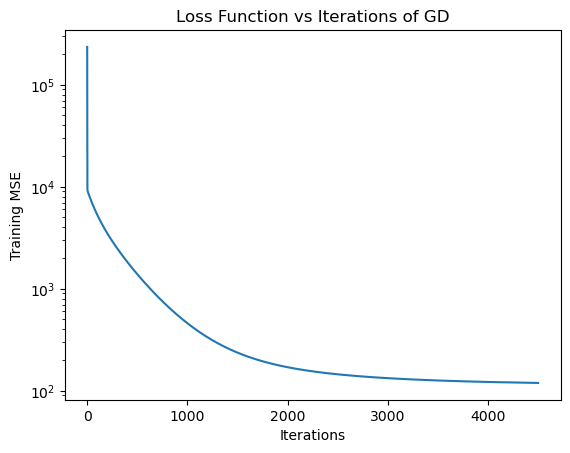

In [15]:
# initialize parameters
alpha = 3.6e-07                             # learning rate       
max_iter = 4500                            # number of iterations

# conduct gradient descent to obtain a multivariate linear regression model + loss function
_, _, MSE = multi_gradient_descent_MSE(X_train, y_train, alpha, max_iter)
plt.plot(range(1, max_iter+1), MSE)
plt.title('Loss Function vs Iterations of GD')
plt.xlabel('Iterations')
plt.ylabel('Training MSE')
plt.yscale('log')
plt.savefig('lossoveriterations.png')
plt.show()

# EXPORT TO CSV

In [16]:
### UNIVARIATE MODEL RESULTS
uvraw = np.vstack((m_uvraw, b_uvraw, train_MSE_uvraw, train_VE_uvraw, test_MSE_uvraw, test_VE_uvraw)).transpose()
uvraw_df = pd.DataFrame(uvraw, columns=['m (slope)', 'b (intercept)', 'Training MSE', 'Training VE', 'Testing MSE', 'Testing VE'])

uvnorm = np.hstack((m_uvnorm, b_uvnorm, train_MSE_uvnorm, train_VE_uvnorm, test_MSE_uvnorm, test_VE_uvnorm))
uvnorm_df = pd.DataFrame(uvnorm, columns=['m (slope)', 'b (intercept)', 'Training MSE', 'Training VE', 'Testing MSE', 'Testing VE'])

uvraw_df.to_csv("univariaterawresults.csv")
uvnorm_df.to_csv("univariatenormresults.csv")

In [17]:
### MULTIVARIATE MODEL RESULTS
mvraw = np.vstack((m_mvraw, b_mvraw, train_MSE_mvraw, train_VE_mvraw, test_MSE_mvraw, test_VE_mvraw))
mvnorm = np.vstack((m_mvnorm, b_mvnorm, train_MSE_mvnorm, train_VE_mvnorm, test_MSE_mvnorm, test_VE_mvnorm))

mv = np.hstack((mvraw, mvnorm))
mv_df = pd.DataFrame(mv, columns=['Raw Predictors', 'Normalized Predictors'])

mv_df.to_csv("multivariateresults.csv")